In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

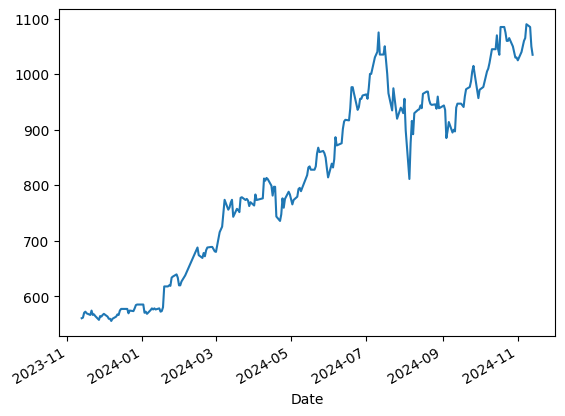

In [2]:
# Fetching stock data
taiwan_2330_stock = yf.Ticker("2330.TW")
data = taiwan_2330_stock.history(period="1y")
data['Close'].plot()  # Plot closing prices

close_prices = data['Close'].values
close_prices_last = close_prices[:-10]
close_prices_next = close_prices[-10:]
num_days = len(close_prices)
input_seq_len = 20
output_seq_len = 10
num_samples = num_days - input_seq_len - output_seq_len + 1


In [3]:
# Prepare data for model input and target sequences
src_data = torch.tensor([close_prices[i:i+input_seq_len] for i in range(num_samples)]).unsqueeze(-1).float()
tgt_data = torch.tensor([close_prices[i+input_seq_len:i+input_seq_len+output_seq_len] for i in range(num_samples)]).unsqueeze(-1).float()


<ipython-input-3-724988879be0>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  src_data = torch.tensor([close_prices[i:i+input_seq_len] for i in range(num_samples)]).unsqueeze(-1).float()


In [4]:
# Check if a GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   ## 如果需要在GPU 上面跑需要加上這個。
print(device)

cuda


In [5]:
# Move data to GPU if available
src_data, tgt_data = src_data.to(device), tgt_data.to(device) ##  data 也需要轉一至GPU 上耶。


In [6]:
# Custom Transformer Model for Stock Price Prediction #用於股票價格預測的自訂變壓器模型
class StockPriceTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout):
        super(StockPriceTransformer, self).__init__()
        self.input_linear = nn.Linear(1, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, dropout=dropout)
        self.output_linear = nn.Linear(d_model, 1)

    def forward(self, src, tgt):
        src = self.input_linear(src)
        tgt = self.input_linear(tgt)
        output = self.transformer(src, tgt)
        output = self.output_linear(output)
        return output


In [7]:
# Model parameters
d_model = 64   ## 這個是 編碼器/解碼器 輸入中預期特徵的數量，表示Transformer 中隱藏維度的大小。
nhead = 4      ##注意力頭的數量，它允許模型同時關注輸入序列的不同部分。
num_layers = 2   ## transformer 中編碼器和解碼器的堆疊層數。
dropout = 0.1


In [8]:
# Initialize model and move to GPU if available
model = StockPriceTransformer(d_model, nhead, num_layers, dropout=dropout).to(device)  ## 模型也需要一置GPU 上。

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [9]:
# Training parameters
epochs = 500
lr = 0.001
batch_size = 16
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [10]:
# Training loop
for epoch in range(epochs):
    for i in range(0, num_samples, batch_size):
        src_batch = src_data[i:i+batch_size].transpose(0, 1).to(device)    ## 在迴圈中的資料，也要移置GPU 上跑耶。
        tgt_batch = tgt_data[i:i+batch_size].transpose(0, 1).to(device)    ## 在迴圈中的資料，也要移置GPU 上跑耶。

        optimizer.zero_grad()
        output = model(src_batch, tgt_batch[:-1])
        loss = criterion(output, tgt_batch[1:])
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/500, Loss: 1062590.8750
Epoch 20/500, Loss: 1012492.0000
Epoch 30/500, Loss: 944509.6250
Epoch 40/500, Loss: 861862.6250
Epoch 50/500, Loss: 768718.5625
Epoch 60/500, Loss: 669939.3125
Epoch 70/500, Loss: 570630.7500
Epoch 80/500, Loss: 474705.5625
Epoch 90/500, Loss: 386500.9062
Epoch 100/500, Loss: 308544.0312
Epoch 110/500, Loss: 242455.2344
Epoch 120/500, Loss: 188441.5938
Epoch 130/500, Loss: 146087.7656
Epoch 140/500, Loss: 114053.5781
Epoch 150/500, Loss: 90591.0547
Epoch 160/500, Loss: 73874.2344
Epoch 170/500, Loss: 62880.3516
Epoch 180/500, Loss: 54260.0039
Epoch 190/500, Loss: 50252.1094
Epoch 200/500, Loss: 46196.5820
Epoch 210/500, Loss: 42837.6914
Epoch 220/500, Loss: 41371.0039
Epoch 230/500, Loss: 40544.3516
Epoch 240/500, Loss: 40186.4609
Epoch 250/500, Loss: 40201.9141
Epoch 260/500, Loss: 40156.7422
Epoch 270/500, Loss: 40081.3867
Epoch 280/500, Loss: 39969.4609
Epoch 290/500, Loss: 40183.2578
Epoch 300/500, Loss: 40009.1680
Epoch 310/500, Loss: 39940.3594
E

In [11]:

# Predicting the next 5 days
src = torch.tensor(close_prices[-input_seq_len:]).unsqueeze(-1).unsqueeze(1).float().to(device)  ## 移置GPU
tgt = torch.zeros(output_seq_len, 1, 1).to(device)  ## 移置GPU


In [12]:
with torch.no_grad():
    for i in range(output_seq_len):
        prediction = model(src, tgt[:i+1])
        tgt[i] = prediction[-1]


In [13]:
output = tgt.cpu().squeeze().tolist()
print("Next 5 days of stock prices:", output)

Next 5 days of stock prices: [850.20263671875, 849.1036376953125, 849.3309936523438, 849.0780639648438, 848.4659423828125, 847.3286743164062, 850.2266845703125, 848.499755859375, 849.8345947265625, 849.503662109375]


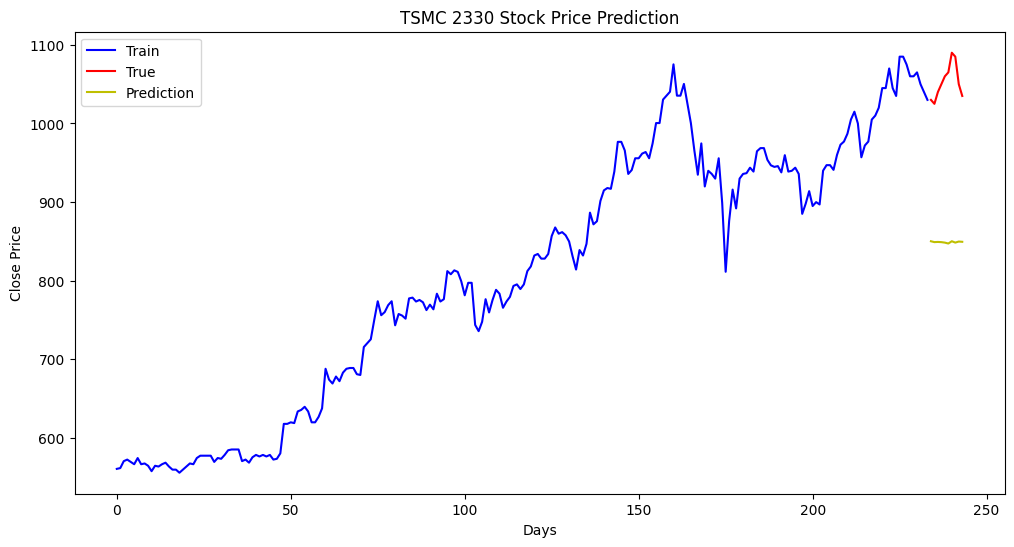

In [14]:


# Prepare and plot predictions
predictions_data = pd.Series(output[0:len(close_prices_next)], index=range(len(close_prices_last), len(close_prices_last) + len(close_prices_next)), name='Date')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(len(close_prices_last)), close_prices_last, 'b', label='Train')
plt.plot(range(len(close_prices_last), len(close_prices)), close_prices_next, 'r', label='True')
plt.plot(range(len(close_prices_last), len(close_prices_last) + len(output)), output, 'y', label='Prediction')
plt.title('TSMC 2330 Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()
